# Heart Disease Predictor

### Environment: Python, Jupyter Notebook, Voila
### Data Source: ['Heart Disease UCI'](https://www.kaggle.com/ronitf/heart-disease-uci)

In [76]:
# Import common libraries, plotting libraries, and ignore warnings
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, IntText
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.cm import rainbow
import seaborn as sns
%matplotlib inline
import requests # csv test
import warnings
warnings.filterwarnings('ignore')

In [77]:
# Import SciKitLearn, Tensorflow, & Keras libraries for ML and analytics
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from keras import regularizers
from keras.utils.np_utils import to_categorical

## Dataset Descriptive Overview

In [78]:
ml_training_filepath = 'https://raw.githubusercontent.com/solo964/C964/main/uciheart.csv'
data = pd.read_csv(ml_training_filepath)
data = data.apply(pd.to_numeric)
data.dtypes
sns.set(style="whitegrid")
data.describe()

age         sex          cp    trestbps        chol         fbs  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean    54.366337    0.683168    0.966997  131.623762  246.264026    0.148515   
std      9.082101    0.466011    1.032052   17.538143   51.830751    0.356198   
min     29.000000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     47.500000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.000000    1.000000    1.000000  130.000000  240.000000    0.000000   
75%     61.000000    1.000000    2.000000  140.000000  274.500000    0.000000   
max     77.000000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  303.000000  303.000000  303.000000  303.000000  303.000000  303.000000   
mean     0.528053  149.646865    0.326733    1.039604    1.399340    0.729373   
std      0.525860   22.905161    0.469794    1.161075    0.616226    1.022606   
min      0.000000   71.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000  133.500000    0.000000    0.000000    1.000000    0.000000   
50%      1.000000  153.000000    0.000000    0.800000    1.000000    0.000000   
75%      1.000000  166.000000    1.000000    1.600000    2.000000    1.000000   
max      2.000000  202.000000    1.000000    6.200000    2.000000    4.000000   

             thal      target  
count  303.000000  303.000000  
mean     2.313531    0.544554  
std      0.612277    0.498835  
min      0.000000    0.000000  
25%      2.000000    0.000000  
50%      2.000000    1.000000  
75%      3.000000    1.000000  
max      3.000000    1.000000

In [79]:
#total percentage of missing data
missing_data = data.isnull().sum()
total_percentage = (missing_data.sum()/data.shape[0]) * 100
print("This function will comb through the orignal .csv dataset to find any null/missing values:")
print(f'The total percentage of missing data is: {round(total_percentage,2)}%')

This function will comb through the orignal .csv dataset to find any null/missing values:
The total percentage of missing data is: 0.0%


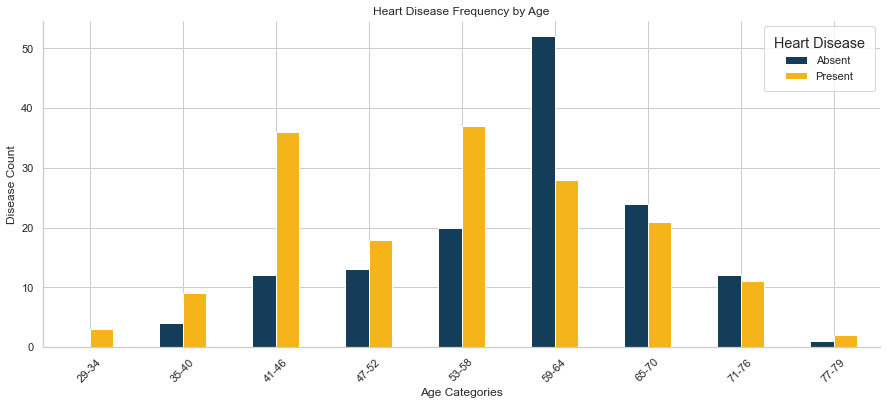

In [80]:
age_data = data.copy()
age_grp = ['29-34', '35-40', '41-46', '47-52', '53-58', '59-64', '65-70', '71-76', '77-79']
age_data['age_cat'] = pd.cut(age_data['age'], 9, labels=age_grp)

age_plt = pd.crosstab(age_data.age_cat, age_data.target)

fig, ax= plt.subplots()
age_plt.plot(kind="bar", figsize=(15,6), color=['#143D59', '#F4B41A'], ax=ax)
plt.title('Heart Disease Frequency by Age')
plt.xlabel('Age Categories')
ax.set_xticklabels(age_grp)
plt.xticks(rotation = 45)
plt.legend(["Absent", "Present"], title="Heart Disease", title_fontsize='large', fancybox=True, borderpad=0.9)
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)
plt.ylabel('Disease Count')
plt.show()

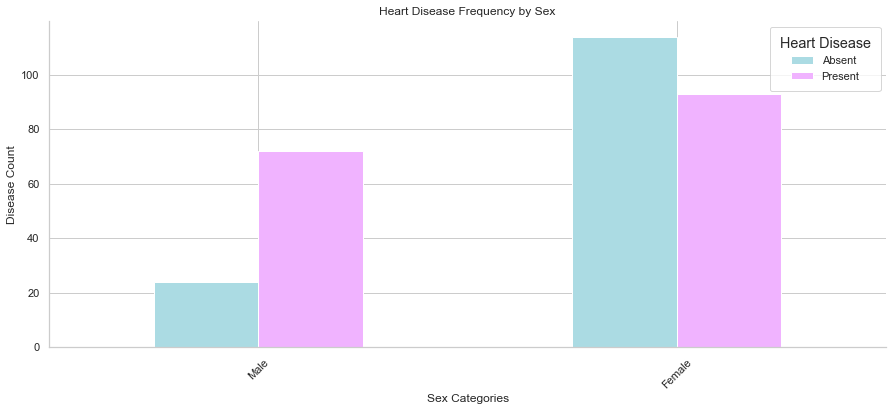

In [81]:
sex_data = data.copy()
sex_grp = ['Male', 'Female']
sex_data['sex_cat'] = pd.cut(sex_data['sex'], 2, labels=sex_grp)

sex_plt = pd.crosstab(sex_data.sex_cat, sex_data.target)

fig, ax= plt.subplots()
sex_plt.plot(kind="bar", figsize=(15,6), color=['#abdbe3', '#f0b3ff'], ax=ax)
plt.title('Heart Disease Frequency by Sex')
plt.xlabel('Sex Categories')
ax.set_xticklabels(sex_grp)
plt.xticks(rotation = 45)
plt.legend(["Absent", "Present"], title="Heart Disease", title_fontsize='large', fancybox=True, borderpad=0.9)
ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False)
plt.ylabel('Disease Count')
plt.show()

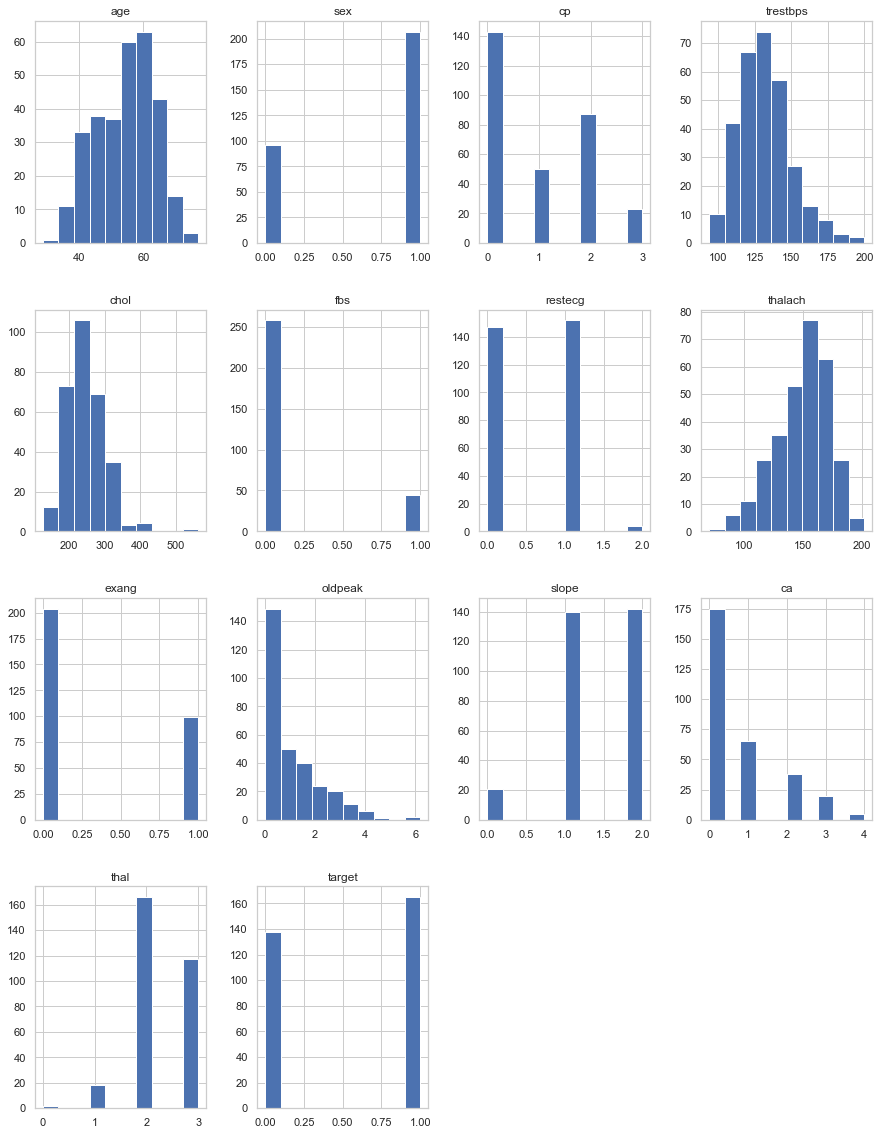

In [82]:
# plot histograms to see the distribution of the attributes
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
data.hist(ax = ax)
plt.show()

<AxesSubplot:>

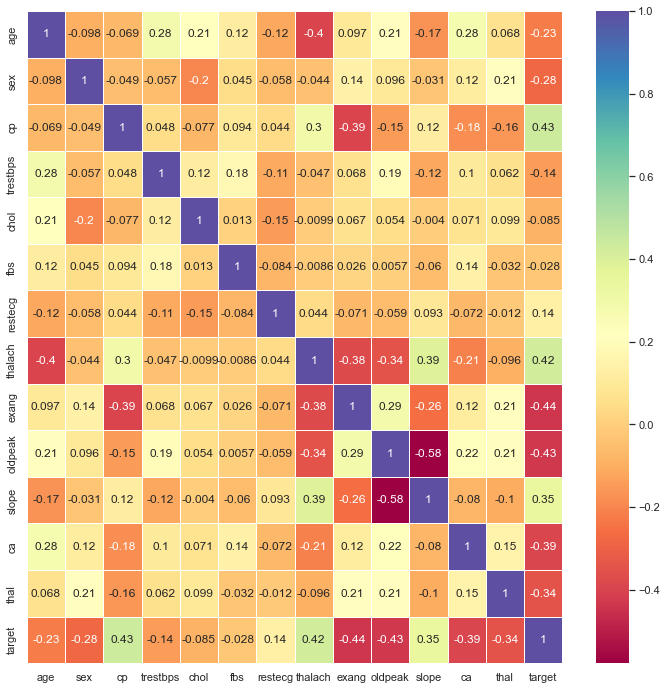

In [83]:
pearsoncorrelation = data.corr(method='pearson')
plt.figure(figsize = (12,12))
sns.heatmap(pearsoncorrelation, xticklabels=pearsoncorrelation.columns, 
            yticklabels=pearsoncorrelation.columns, 
            cmap='Spectral', annot=True, linewidth=0.5)

In [84]:
# We now begin to use our dataset for machhine learning. 
# We choose to drop exang, oldpeak, and ca variables as they had the most negative statistical correlations in your heatmap.
X = data[['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'slope', 'thal']]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

In [85]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Y_train = to_categorical(y_train, num_classes=None)
Y_test = to_categorical(y_test, num_classes=None)

In [86]:
lr = LogisticRegression(max_iter = 10000)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
lra = accuracy_score(y_test,y_pred)
lr_acs = lra*100
print('Accuracy Score = ', lr_acs)

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=1))
pipe_lr.fit(X_train, y_train)
lr_pacs = pipe_lr.score(X_test, y_test)*100
print('\nPipeline Accuracy Score = ', lr_pacs)

print("\nClassification Report\n\n",classification_report(y_test,y_pred))

Accuracy Score =  77.04918032786885

Pipeline Accuracy Score =  77.04918032786885

Classification Report

               precision    recall  f1-score   support

           0       0.69      0.75      0.72        24
           1       0.83      0.78      0.81        37

    accuracy                           0.77        61
   macro avg       0.76      0.77      0.76        61
weighted avg       0.77      0.77      0.77        61



### The ROC Curve summarizes the difference between the true positive rate and the false positive rate for the predictive model. Our ROC score is ~0.76689:

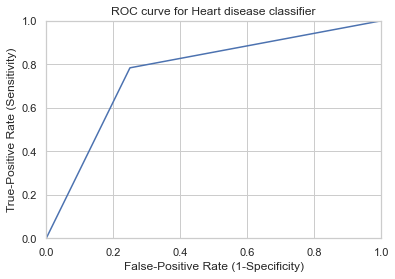

In [87]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Heart disease classifier')
plt.xlabel('False-Positive Rate (1-Specificity)')
plt.ylabel('True-Positive Rate (Sensitivity)')
plt.grid(True)
import sklearn

### Slider Attributes:

* Age: -
* Sex: -
* cp: Chest pain type (0-3)
* trestbps: Resting blood pressure
* chol: serum cholesterol (mg/dl)
* fbs: fasting blood sugarr
* restecg: resting electrocardiograph results (0-2)
* thalach: maximum heart rate achieved
* slope: slope of peak exercise ST segment
* thal: 3 = normal; 6 = fixed defect; 7 = reversible defect

In [88]:
# Widget sliders collect input and are passed to calculate_prediction function with button press
i_age = widgets.IntSlider(min=29, max=77, step=1, description='Age')
i_sex = widgets.IntSlider(min=0, max=1, step=1, description='Sex')
i_cp = widgets.IntSlider(min=0, max=3, step=1, description='cp')
i_trestbps = widgets.IntSlider(min=94, max=200, step=1, description='trestbps')
i_chol = widgets.IntSlider(min=126, max=564, step=1, description='chol')
i_fbs = widgets.IntSlider(min=0, max=1, step=1, description='fbs')
i_restecg = widgets.IntSlider(min=0, max=2, step=1, description='restecg')
i_thalach = widgets.IntSlider(min=71, max=202, step=1, description='thalach')
i_slope = widgets.IntSlider(min=0, max=2, step=1, description='slope')
i_thal = widgets.IntSlider(min=0, max=3, step=1, description='thal')
widget_box = widgets.VBox([i_age, i_sex, i_cp, i_trestbps, i_chol, i_fbs, i_restecg, i_thalach, i_slope, i_thal])
# List of widget box children for tab
children = [widget_box]
# Initialize tab and set children
tab = widgets.Tab()
tab.children = children
# Box title
tab.set_title(0, 'Health Values')
tab

In [89]:
X = data[['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'slope', 'thal']]
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

lrs = LogisticRegression(max_iter = 10000)
lrs.fit(X_train, y_train)
pipe_lrs = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=1))
pipe_lrs.fit(X_train, y_train)

# define predictor function for use with button
def predict_risk(i_age, i_sex, i_cp, i_trestbps, i_chol, i_fbs, i_restecg, i_thalach, i_slope, i_thal):
    predicted_risk = lrs.predict([[
        i_age.value,
        i_sex.value,
        i_cp.value,
        i_trestbps.value, 
        i_chol.value, 
        i_fbs.value, 
        i_restecg.value, 
        i_thalach.value,  
        i_slope.value, 
        i_thal.value]])
    return predicted_risk

In [90]:
def on_button_clicked(_):
    # Link function with output
    pred = predict_risk(i_age, i_sex, i_cp, i_trestbps, i_chol, i_fbs, i_restecg, i_thalach, i_slope, i_thal)
    # what happens when we press the button
    with out:
        out.clear_output()
        print("--Prediction--")
        if pred == 1:
            print("The model predicts:", pred, "Likely risk of heart disease.")
        else:
            print("The model predicts:", pred, "Low risk of heart disease.")
    return

# calculate_prediction execution button harvest input from sliders
predict_button = widgets.Button(description='Calculate')
out = widgets.Output()

# Link button and function together using button method
predict_button.on_click(on_button_clicked)
# Display button and output together
widgets.VBox([predict_button,out])